In [1]:
%matplotlib notebook
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))
core_count = 12

Running on PyMC3 v3.8


In [2]:
def SuperNova_CurveRise(t, A, B, t0, trise):
    return ((A+B*(t-t0))/(1+np.exp(-(t-t0)/trise)))
def SuperNova_CurveFall(t, A, B, t0, t1, trise, tfall):
    return (A + B*(t1-t0))*np.exp(-(t-t1)/tfall)/(1+np.exp(-(t-t0)/trise))

In [3]:
#These are the values we are going to use for a test
np.random.seed(212)
trise_A = .3
tfall_A = 2
Amplitude_A = 10.5
Beta_A = -.4
t0_A = 6.7
t1_A = float(15)
end_A = 50
size = 50 #data set size
sigma_A = 1 #Telescope error

In [4]:
time_axis_rise = np.random.uniform(low=0, high=t1_A, size=size)
time_axis_fall = np.random.uniform(low=t1_A, high=end_A, size=size)
Y_actual_rise = SuperNova_CurveRise(time_axis_rise, Amplitude_A, Beta_A, t0_A, trise_A)
Y_actual_fall = SuperNova_CurveFall(time_axis_fall, Amplitude_A, Beta_A, t0_A, t1_A, trise_A, tfall_A)
time_axis = np.append(time_axis_rise, time_axis_fall)
Y_actual = np.append(Y_actual_rise, Y_actual_fall)
Y_observed = Y_actual + np.random.normal(0,sigma_A, len(Y_actual))

<IPython.core.display.Javascript object>


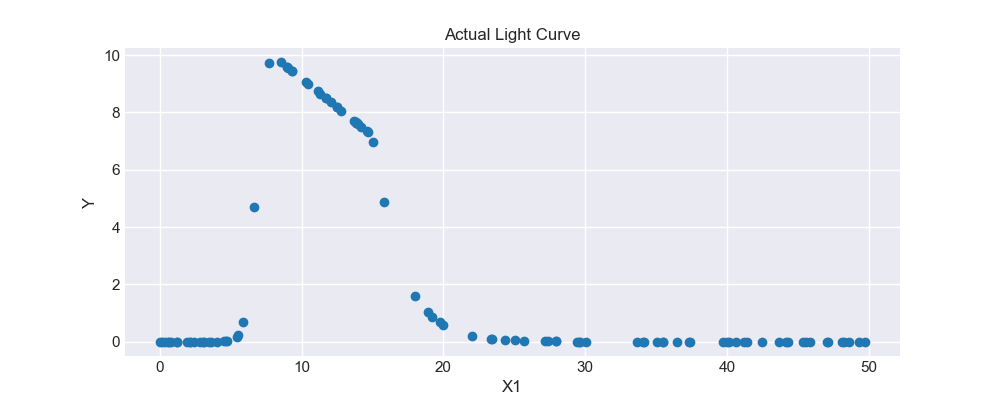

Text(0.5, 1.0, 'Actual Light Curve')

In [5]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_actual)
axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Actual Light Curve")

<IPython.core.display.Javascript object>


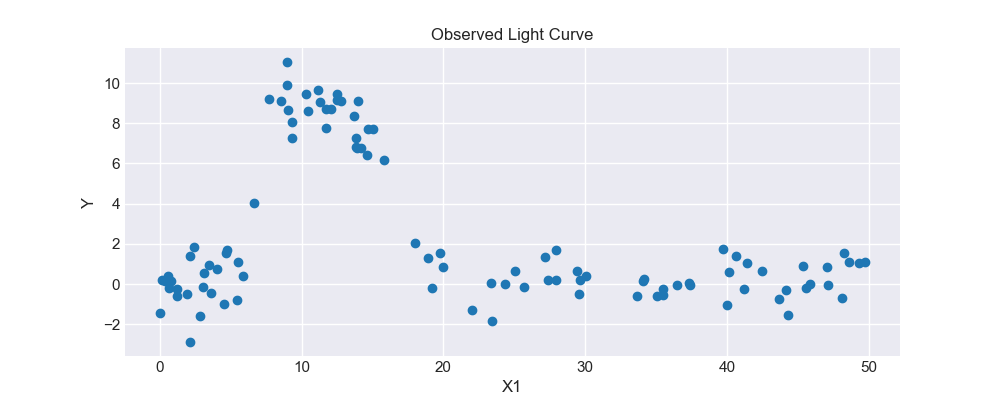

Text(0.5, 1.0, 'Observed Light Curve')

In [6]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10,4))
axes.scatter(time_axis, Y_observed)
axes.set_ylabel('Y')
axes.set_xlabel('X1')
plt.title("Observed Light Curve")

In [7]:
basic_model = pm.Model()

In [8]:
with basic_model:

    # Priors for unknown model parameters
    AboveZeroBound = pm.Bound(pm.Normal, lower = 0.0)
    BelowZeroBound = pm.Bound(pm.Normal, upper = 0.0)
    trise = AboveZeroBound('trise', mu=0, sigma=10)
    tfall = AboveZeroBound('tfall', mu=0, sigma=10)
    Amplitude = AboveZeroBound('Amplitude', mu=np.max(Y_observed)-np.min(Y_observed), sigma=1)
    Beta = BelowZeroBound('Beta', mu=0, sigma=10)
    t0 = AboveZeroBound('t0', mu=0, sigma=10)
    t1 = pm.DiscreteUniform('t1', lower = np.min(time_axis), upper = np.max(time_axis))
    sigma = pm.HalfNormal('sigma', sigma=sigma_A)
    
    # Expected value of outcome
    mu_rise = SuperNova_CurveRise(time_axis, Amplitude, Beta, t0, trise)
    mu_fall = SuperNova_CurveFall(time_axis, Amplitude, Beta, t0, t1, trise, tfall)
    
    mu_switch = pm.math.switch(t1 >= time_axis, mu_rise, mu_fall)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu_switch, sigma=sigma, observed=Y_observed)

In [9]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

logp = -173.03, ||grad|| = 0.26131: 100%|████████████████████████████████████████████| 83/83 [00:00<00:00, 2460.82it/s]


{'trise_lowerbound__': array(-4.56042722),
 'tfall_lowerbound__': array(-2.00907349),
 'Amplitude_lowerbound__': array(2.51663747),
 'Beta_upperbound__': array(-0.22411546),
 't0_lowerbound__': array(1.8932875),
 't1': array(24, dtype=int64),
 'sigma_log__': array(0.10546138),
 'trise': array(0.01045759),
 'tfall': array(0.13411287),
 'Amplitude': array(12.38687526),
 'Beta': array(-0.79922285),
 't0': array(6.64116569),
 'sigma': array(1.11122319)}

In [10]:
with basic_model:
    # 1000 posterior samples
    trace = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma, t0, Beta, Amplitude, tfall, trise]
>Metropolis: [t1]
Sampling 4 chains, 86 divergences: 100%|█████████████████████████████████████| 42000/42000 [00:42<00:00, 998.93draws/s]
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\ProgramData\Anaconda3\envs\Astronomy\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotl

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002220AF6EB88>,
      dtype=object)

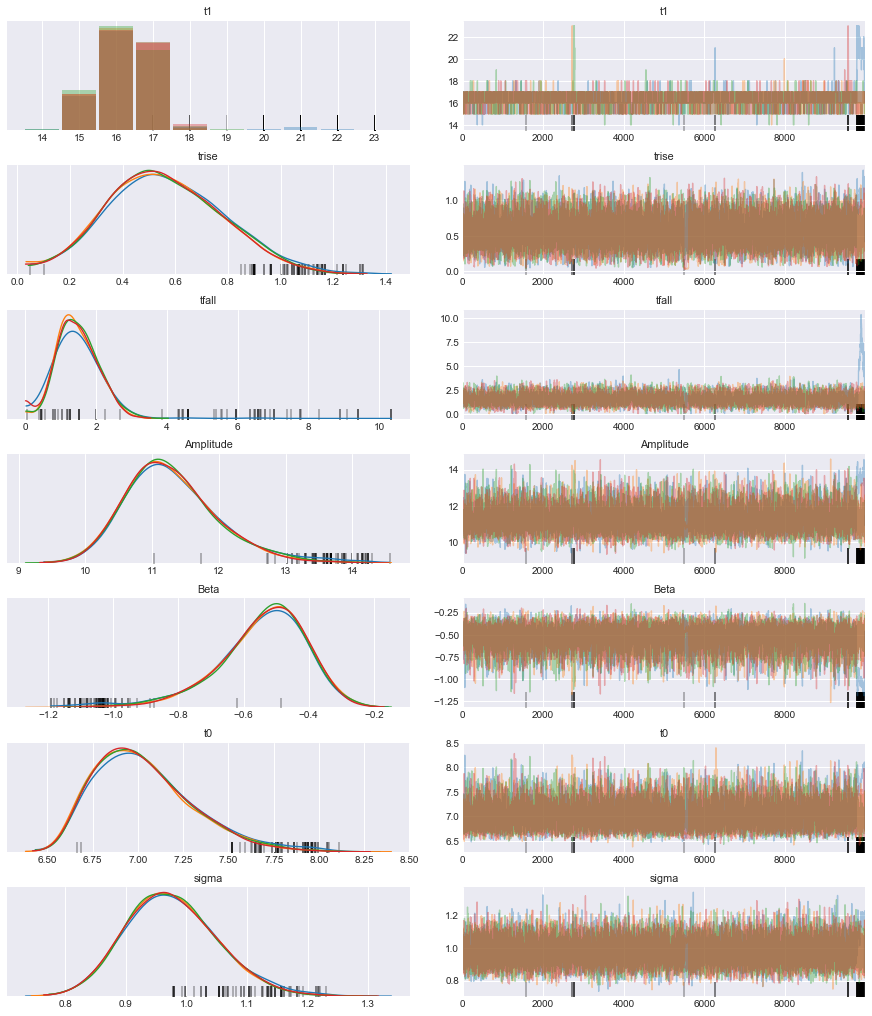

In [11]:
%matplotlib inline
pm.traceplot(trace)

In [12]:
summary_table = pm.summary(trace)
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
t1,16.278,0.844,15.000,17.000,0.029,0.022,875.0,753.0,1687.0,713.0,1.0
trise,0.561,0.218,0.155,0.972,0.003,0.003,4089.0,3713.0,3729.0,3483.0,1.0
tfall,1.488,0.655,0.494,2.667,0.021,0.022,983.0,463.0,2522.0,2815.0,1.0
Amplitude,11.302,0.700,10.094,12.674,0.014,0.010,2592.0,2290.0,4043.0,1780.0,1.0
Beta,-0.543,0.137,-0.799,-0.299,0.003,0.003,2131.0,1370.0,3656.0,1797.0,1.0
t0,7.036,0.270,6.606,7.552,0.005,0.003,3535.0,3354.0,4413.0,2194.0,1.0
sigma,0.976,0.075,0.841,1.120,0.001,0.001,8735.0,8041.0,9930.0,4450.0,1.0


In [13]:
trise_R = summary_table["mean"]["trise"]
tfall_R = summary_table["mean"]["tfall"]
Amplitude_R = summary_table["mean"]["Amplitude"]
Beta_R = summary_table["mean"]["Beta"]
t0_R = summary_table["mean"]["t0"]
t1_R = summary_table["mean"]["t1"]

In [14]:
print(trise_R)
print(tfall_R)
print(Amplitude_R)
print(Beta_R)
print(t0_R)
print(t1_R)

0.561
1.488
11.302
-0.543
7.036
16.278


<IPython.core.display.Javascript object>


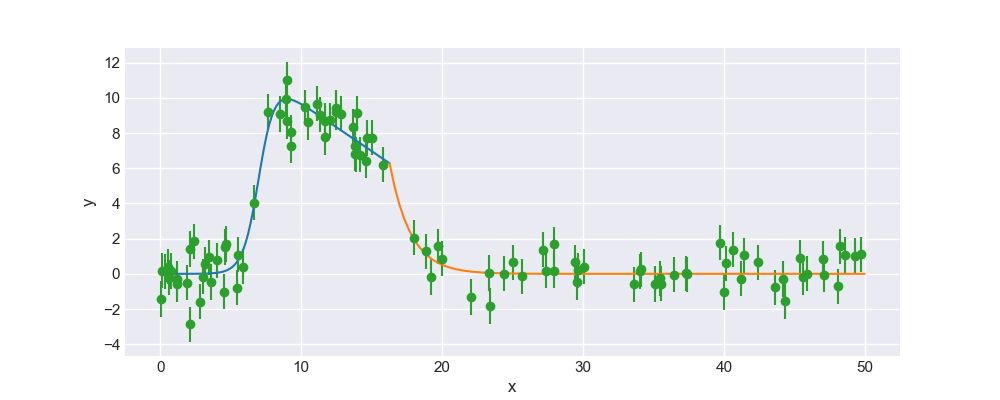

Text(0, 0.5, 'y')

In [18]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t1_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t1_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, t1_R, trise_R, tfall_R))

ax.errorbar(time_axis, Y_observed, sigma_A, fmt='o')
ax.set_xlabel('x')
ax.set_ylabel('y')

<IPython.core.display.Javascript object>


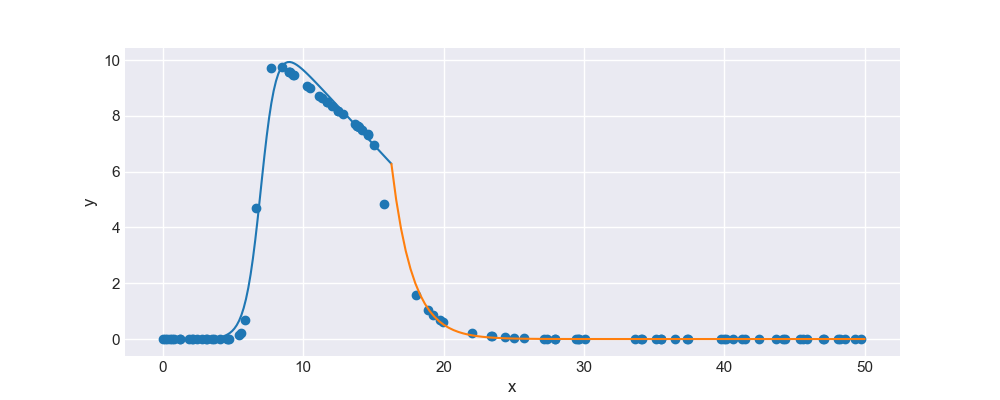

Text(0, 0.5, 'y')

In [17]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,4))

big_time_axis_rise = np.linspace(0,t1_R,num = 100)
ax.plot(big_time_axis_rise, SuperNova_CurveRise(big_time_axis_rise, Amplitude_R, Beta_R, t0_R, trise_R))

big_time_axis_fall = np.linspace(t1_R,end_A,num = 100)
ax.plot(big_time_axis_fall, SuperNova_CurveFall(big_time_axis_fall, Amplitude_R, Beta_R, t0_R, t1_R, trise_R, tfall_R))

ax.scatter(time_axis, Y_actual)
ax.set_xlabel('x')
ax.set_ylabel('y')